In [1]:
import pathlib
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\carso\Anaconda3\envs\tflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(tf.__version__)

1.10.0


# Retrieve the mpg dataset 

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

C:\Users\carso\.keras\datasets\auto-mpg.data


In [4]:
column_names = [
    "MPG", "Cylinders", "Displacement",
    "Horsepower", "Weight", "Acceleration",
    "Model Year", "Origin"
]

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment="\t",
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


# Clean the data

In [5]:
dataset.isna().sum()

# Let's drop these rows
dataset = dataset.dropna()
origin = dataset.pop("Origin")

# convert origin to a one-hot
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


## Split into train and test sets

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print("Train data shape: {}, Test data shape: {}".format(
    train_dataset.shape, test_dataset.shape
))

Train data shape: (314, 10), Test data shape: (78, 10)


## Inspect the data

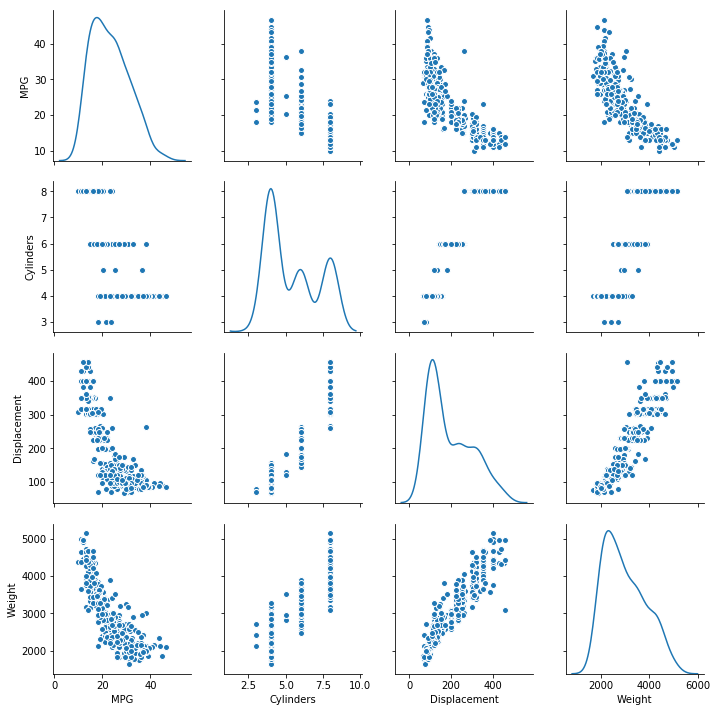

In [7]:
sns.pairplot(
    train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],
    diag_kind="kde"
)

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Split features from labels

In [9]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

## Normalize the data
Use ONLY the statistics (mean/std) from the TRAINING set

In [10]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


# The model

## Build the model

In [11]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu,
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=["mae", "mse"]
    )
    return model

In [12]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.02822725],
       [-0.02317962],
       [ 0.5908941 ],
       [-0.2103799 ],
       [ 0.18427438],
       [ 0.10022292],
       [ 0.25207677],
       [ 0.82017076],
       [ 0.2652575 ],
       [ 0.23365708]], dtype=float32)

## Train the model

In [14]:
# Print a single dot for a completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print("")
        print(".", end="")

EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.552302,1.044074,2.552302,10.622772,2.420022,10.622772,995
996,2.239695,0.938045,2.239695,11.138723,2.487152,11.138723,996
997,2.605066,1.091840,2.605066,11.044125,2.461494,11.044125,997
998,2.223129,0.951373,2.223129,11.157424,2.512713,11.157424,998
999,2.325107,0.965945,2.325107,10.929297,2.554571,10.929297,999


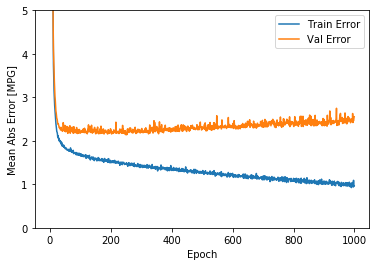

<Figure size 432x288 with 0 Axes>

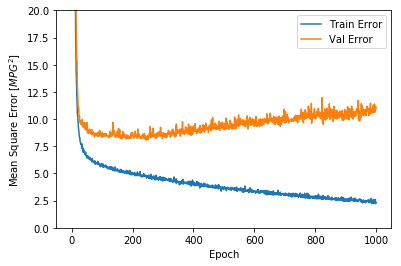

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mean_absolute_error"],
             label="Train Error")
    plt.plot(hist["epoch"], hist["val_mean_absolute_error"],
             label="Val Error")
    plt.legend()
    plt.ylim([0, 5])
    plt.show()
    plt.clf()
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist["epoch"], hist["mean_squared_error"],
             label="Train Error")
    plt.plot(hist["epoch"], hist["val_mean_squared_error"],
             label="Val Error")
    plt.legend()
    plt.ylim([0, 20])
    plt.show()
    plt.clf()

plot_history(history)

## Stop training the model once it's no longer improving


....................................................................................................
....................................................................................................
.................

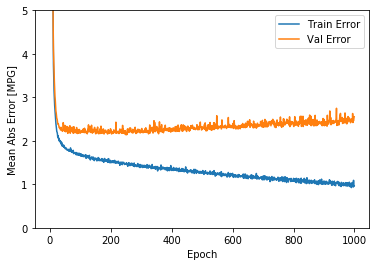

<Figure size 432x288 with 0 Axes>

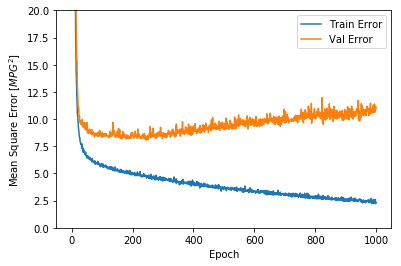

<Figure size 432x288 with 0 Axes>

In [18]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",
                                           patience=50)
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels,
                                verbose=0)
print("Test set MAE: {:5.2f}".format(mae))

Test set MAE:  2.00


## Make predictions

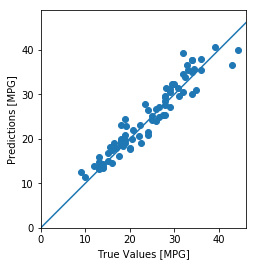

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

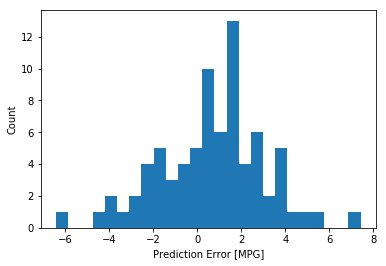

<Figure size 432x288 with 0 Axes>

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()
plt.clf()